In [14]:
#se importan las librerias
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

nm=1e-9
um=1e-6
mm=1e-3
cm=1e-2

In [2]:
def ZonasFresnel(z,W_l,a,b):
    R = [0]*(np.abs(b-a))
    for i in range(a,b):
        R[i] = np.sqrt((i*z*W_l)/2)
    return R      

In [3]:
(ZonasFresnel(30,650*nm,0,5))

[0.0,
 0.003122498999199199,
 0.004415880433163924,
 0.005408326913195984,
 0.006244997998398398]

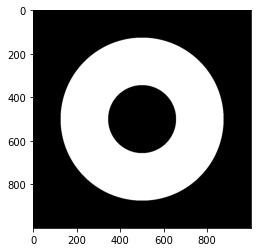

In [27]:
#Apertura circular
mask=np.zeros((1000,1000),dtype="uint8")
cv2.circle(mask,(500,500),374,1,-1)
cv2.circle(mask,(500,500),156,0,-1)
plt.imshow(mask,cmap="gray")


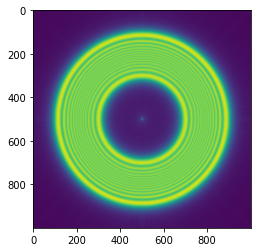

In [33]:
#Transformada de Fresnel FFT
def TrFr(entrada,z,dx,dy,W_l):
    #Contenido frecuencial de la imagen (transformada de fourier)
    k= 2*np.pi/W_l
    N,M= np.shape(entrada)
    x=np.arange(-int(N/2),int(N/2),1)
    y=np.arange(-int(M/2),int(M/2),1)
    X, Y=np.meshgrid(x,y)
    X_0, Y_0 =np.meshgrid(x,y)

    #concidion de buen muestreo
    dx_0=(W_l*z)/(M*dx)
    dy_0=(W_l*z)/(N*dy)

    #Constante de U_0
    C1= ((1j*k)/(2*z))

    U_1 = entrada*np.exp(C1*(((X_0*dx_0)**2) + ((Y_0*dy_0)**2)))

    U_2 = np.fft.fft2(U_1)

    #Constantes de U_2
    C2= np.exp(1j*k*z)/(1j*W_l*z)
    C3= ((1j*k)/(2*z))

    U_3= U_2*C2*np.exp(C3*(((X*dx)**2) + ((Y*dy)**2)))
    
    return U_3

plt.imshow(np.abs(np.fft.fftshift((TrFr(mask,1.7,1,1,650)))))
plt.show()
    

In [34]:
%matplotlib qt

In [35]:
#Tranferencia de Fresnel

def T_Aprox(T_f,z,dx,dy,wavelength):
    #Contenido frecuencial de la imagen (transformada de fourier)
    T_freq=np.fft.fftshift(np.fft.fft2(T_f))
    #Se define el espacio de coordenadas según la imagen que hace de U_0
    N,M= np.shape(T_f)
    x=np.arange(-int(N/2),int(N/2),1)
    y=np.arange(-int(M/2),int(M/2),1)
    X, Y=np.meshgrid(x,y)

    #dimensiones de mundo en frecuencias
    fx=X*(1/(N*dx))
    fy=Y*(1/(M*dy))

    #vector de onda Y constantes de e^{ikz} .....
    k= 2*np.pi/wavelength
    C1=np.exp(1j*k*z)
    C2=-1j*np.pi*wavelength*z

    #Tranformada H(f_x,f_y)
    Tran=C1*np.exp(C2*((fx**2)+(fy**2)))

    #U(x,y,z)
    U_resultante=Tran*T_freq

    return U_resultante

plt.imshow(np.abs(np.fft.ifft2((T_Aprox(mask,1*mm,1*um,1*um,650*nm)))))
plt.show()
    
